In [16]:
import numpy as np
from mpmath import mp
from tqdm import tqdm
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization_hp import *

mp.dps = 100  # Set desired precision

plus_configs = [
    ([1,1,1], lambda J1, J2: 2*J1 + J2),
    ([1,1,-1], lambda J1, J2: -J2),
    ([1,-1,1], lambda J1, J2: -2*J1 + J2),
    ([-1,1,1], lambda J1, J2: -J2)
]

minus_configs = [
    ([-1,-1,-1], lambda J1, J2: 2*J1 + J2),
    ([-1,-1,1], lambda J1, J2: -J2),
    ([-1,1,-1], lambda J1, J2: -2*J1 + J2),
    ([1,-1,-1], lambda J1, J2: -J2)
]

def get_J(d, J0, n):
    if d <= 0:
        return mp.mpf(0)
    return mp.mpf(J0) / mp.power(mp.mpf(d), mp.mpf(n))

def compute_J_prime_func(start, J_func):
    J1 = J_func(1)
    J2 = J_func(2)
    distances = []
    for iL in range(3):
        for iR in range(3):
            d = (start + iR) - (1 + iL)
            distances.append((iL, iR, d))

    def collect_totals(is_pp):
        confsR = plus_configs if is_pp else minus_configs
        totals = []
        for spinsL, El_func in plus_configs:
            El = El_func(J1, J2)
            for spinsR, Er_func in confsR:
                Er = Er_func(J1, J2)
                Eint = mp.mpf(0)
                for iL_idx, iR_idx, d in distances:
                    sign = mp.mpf(spinsL[iL_idx] * spinsR[iR_idx])
                    Eint += sign * J_func(d)
                total = El + Er + Eint
                totals.append(total)
        return totals

    totals_pp = collect_totals(True)
    totals_pm = collect_totals(False)
    log_R_pp = mp_logsumexp(totals_pp)
    log_R_pm = mp_logsumexp(totals_pm)
    if log_R_pm == mp.ninf:
        return mp.inf
    return mp.mpf('0.5') * (log_R_pp - log_R_pm)

def mp_logsumexp(lst):
    if not lst:
        return mp.ninf
    a_max = max(lst)
    if mp.isinf(a_max):
        return a_max
    tmp = sum(mp.exp(a - a_max) for a in lst)
    return a_max + mp.log(tmp)

def generate_rg_flow_no_viz(J0, n, max_k, num_steps):
    J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
    rs = list(range(1, max_k + 1))
    initial_Js = [J_func(r) for r in rs]
    all_Js = [initial_Js]
    for step in range(1, num_steps + 1):
        Jps = []
        for r in rs:
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func)
            Jps.append(Jp)
        all_Js.append(Jps)
        J_dict = {r: Jps[r-1] for r in rs}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
    return all_Js

def construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size=5, epsilon=1e-6):
    all_Js = generate_rg_flow_no_viz(J0, n, max_k, num_steps)
    if len(all_Js) < 2:
        raise ValueError("Need at least 2 steps for derivatives")
    
    # Extract first matrix_size from last two steps
    J_k_minus_1 = all_Js[-2][:matrix_size]  # list of mp.mpf, truncated
    J_k = all_Js[-1][:matrix_size]  # list of mp.mpf, truncated
    
    M = matrix_size  # Size of matrix
    jac = np.zeros((M, M))
    
    # Define compute_T truncated to M
    def compute_T(J_vec_mp):
        J_dict = {r+1: J_vec_mp[r] for r in range(M)}
        J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)
        J_prime = []
        for r in range(1, M+1):
            start = 3 * r + 1
            Jp = compute_J_prime_func(start, J_func)
            J_prime.append(Jp)
        return J_prime
    
    epsilon_mp = mp.mpf(epsilon)
    
    for s in range(M):
        J_pert_mp = [j for j in J_k_minus_1]  # copy list of mp
        J_pert_mp[s] += epsilon_mp
        T_pert_mp = compute_T(J_pert_mp)
        T_pert_float = np.array([float(j) for j in T_pert_mp])
        J_k_float = np.array([float(j) for j in J_k])
        jac[:, s] = (T_pert_float - J_k_float) / epsilon
    
    return jac

In [17]:
# Use case example
J0 = 2.0  # Initial J0
n = 1.5  # Exponent n
max_k = 1000  # Max distance for flow (thousands)
num_steps = 5  # Number of RG steps
matrix_size = 5  # Number of first J values for matrix

M_matrix = construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size=matrix_size)
print("Recursion Matrix M:")
print(M_matrix)

# Optional: Compute exponents from the matrix
eigenvalues = np.linalg.eigvals(M_matrix)
eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
lambda_t = eigenvalues[0]
b = 3  # Scale factor
y = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0
nu = 1 / y if y != 0 else np.inf
alpha = 2 - 1 / y if y != 0 else -np.inf
print(f"Largest eigenvalue λ_t = {lambda_t:.6f}")
print(f"ν = {nu:.6f}, α = {alpha:.6f}")

Recursion Matrix M:
[[ 9.99999997e-01  1.99999999e+00  2.00041396e+00  1.99999999e+00
   9.99999997e-01]
 [-6.38351080e+06 -6.38351080e+06 -6.38351080e+06 -6.38350980e+06
  -6.38350880e+06]
 [-6.14551337e+06 -6.14551337e+06 -6.14551337e+06 -6.14551337e+06
  -6.14551337e+06]
 [-3.92732295e+06 -3.92732295e+06 -3.92732295e+06 -3.92732295e+06
  -3.92732295e+06]
 [-2.78969924e+06 -2.78969924e+06 -2.78969924e+06 -2.78969924e+06
  -2.78969924e+06]]
Largest eigenvalue λ_t = -19246044.020628+0.000000j
ν = 0.065500, α = 1.934500


n=0.80, J0=1.000000, λ_t=-3317535.308021+0.000000j, ν=0.073169, α=1.926831
n=0.93, J0=1.000000, λ_t=-1176348.411281+0.000000j, ν=0.078596, α=1.921404
n=1.06, J0=1.000000, λ_t=-417636.776141+0.000000j, ν=0.084885, α=1.915115
n=1.20, J0=1.000000, λ_t=-148352.480072+0.000000j, ν=0.092263, α=1.907737
n=1.33, J0=1.000000, λ_t=-52665.763888+0.000000j, ν=0.101052, α=1.898948
n=1.46, J0=1.000000, λ_t=-18657.060118+0.000000j, ν=0.111716, α=1.888284
n=1.59, J0=1.000000, λ_t=-6580.186304+0.000000j, ν=0.124958, α=1.875042
n=1.73, J0=1.000000, λ_t=-2298.765241, ν=0.141937, α=1.858063
n=1.86, J0=1.000000, λ_t=-783.128006, ν=0.164875, α=1.835125
n=1.99, J0=1.000000, λ_t=-237.359590, ν=0.200859, α=1.799141


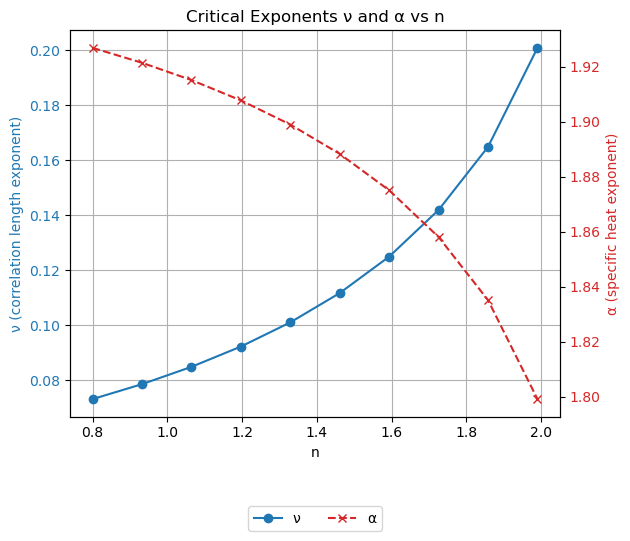

In [21]:
def calculate_exponents(n_values, max_k=1000, num_steps=10, matrix_size=5, b=3, epsilon=1e-6):
    nu_values = []
    alpha_values = []
    #for n in n_values:
    for _, n in enumerate(tqdm(n_values)):
        try:
            # Get critical J0 using find_J_c
            J0 = 1 #float(find_J_c(n, max_k=max_k, tol=1e-6, J_low=1e-10, J_high=3.0))
            # Construct recursion matrix
            M_matrix = construct_recursion_matrix(J0, n, max_k, num_steps, matrix_size, epsilon)
            # Get eigenvalues, take largest by absolute value
            eigenvalues = np.linalg.eigvals(M_matrix)
            eigenvalues = sorted(eigenvalues, key=abs, reverse=True)
            lambda_t = eigenvalues[0]
            # Compute scaling dimension y
            y = np.log(abs(lambda_t)) / np.log(b) if abs(lambda_t) > 0 else 0
            # Compute exponents
            nu = 1 / y if y != 0 else np.inf
            alpha = 2 - 1 / y if y != 0 else -np.inf
            nu_values.append(nu)
            alpha_values.append(alpha)
            print(f"n={n:.2f}, J0={J0:.6f}, λ_t={lambda_t:.6f}, ν={nu:.6f}, α={alpha:.6f}")
        except Exception as e:
            print(f"n={n:.2f}, error: {e}")
            nu_values.append(np.nan)
            alpha_values.append(np.nan)
    return nu_values, alpha_values

# Generate n values
n_values = np.linspace(0.8, 1.99, 10)
nu_values, alpha_values = calculate_exponents(n_values, max_k=5000, num_steps=6, matrix_size=5, b=3, epsilon=1e-3)

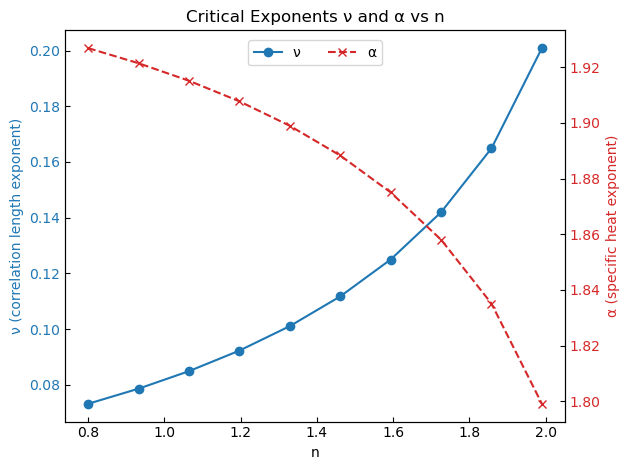

In [38]:
# Plot ν and α vs n
fig, ax1 = plt.subplots()
# Plot ν on left y-axis
color_nu = 'tab:blue'
ax1.set_xlabel('n')
ax1.set_ylabel('ν (correlation length exponent)', color=color_nu)
ax1.plot(n_values, nu_values, marker='o', linestyle='-', color=color_nu, label='ν')
ax1.tick_params(axis='x', direction='in')
ax1.tick_params(axis='y', labelcolor=color_nu, direction='in')
ax1.grid(False)
# Create second y-axis for α
ax2 = ax1.twinx()
color_alpha = 'tab:red'
ax2.set_ylabel('α (specific heat exponent)', color=color_alpha)
ax2.plot(n_values, alpha_values, marker='x', linestyle='--', color=color_alpha, label='α')
ax2.tick_params(axis='y', labelcolor=color_alpha, direction='in')
# Title and layout
plt.title('Critical Exponents ν and α vs n')
fig.tight_layout()
fig.legend(loc='upper center',
           bbox_to_anchor=(0.5, .92),
           ncol=2)
plt.savefig('../results/exponents.png')
plt.show()